https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection

In [1]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [55]:
from tqdm.auto import tqdm
import librosa

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

# Data


In [3]:
import os
os.chdir('/Users/lhs/Desktop/Machine_Sound_Data')

train_df = pd.read_csv('./train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./test.csv')

### Hyperparameter Setting

In [10]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

In [11]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features

In [106]:
train_features = get_mfcc_feature(train_df)
test_features = get_mfcc_feature(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

In [107]:
train1 = pd.DataFrame(data = train_features)
train_mfcc = pd.concat([train1, train_df.iloc[:, 2:3]], axis = 1)
test1 = pd.DataFrame(data = test_features)
test_mfcc = pd.concat([test1, test_df['FAN_TYPE']], axis = 1)

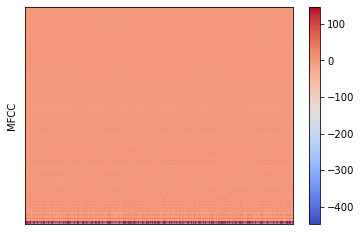

In [26]:
import librosa.display

librosa.display.specshow(train_features)
plt.ylabel('MFCC')
plt.colorbar()

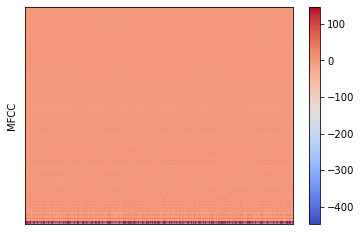

In [27]:
librosa.display.specshow(train_features)
plt.ylabel('MFCC')
3 plt.colorbar()

# Models

### Isolation Forest

In [118]:
train_mfcc.iloc[129]

0          -335.180420
1            97.775536
2           -13.131641
3            23.653833
4            -8.957332
               ...    
124          -0.401025
125          -0.189439
126          -0.751755
127          -0.223009
FAN_TYPE      2.000000
Name: 129, Length: 129, dtype: float64

In [216]:
outliers_fraction = 0.5

# Take useful feature and standardize them 
data = train_mfcc.iloc[:,:128]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data = pd.concat([data, train_mfcc.FAN_TYPE], axis=1)

# train isolation forest 
model =  IsolationForest(n_estimators=200, max_samples=256, random_state=44, verbose=0, contamination = outliers_fraction)
model.fit(data)

# add the data to the main  
train_mfcc['LABEL'] = pd.Series(model.predict(data))
train_mfcc['LABEL'] = train_mfcc['LABEL'].map( {1: 0, -1: 1} )
print(train_mfcc['LABEL'].value_counts())

0    640
1    639
Name: LABEL, dtype: int64


In [66]:
'''
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = train_mfcc.loc[train_mfcc['LABEL'] == 1] #anomaly

ax.plot(train_mfcc.columns, train_mfcc, color='blue')
ax.scatter(a.columns, a, color='red')
plt.show()
'''

"\n# visualisation of anomaly throughout time (viz 1)\nfig, ax = plt.subplots()\n\na = train_mfcc.loc[train_mfcc['LABEL'] == 1] #anomaly\n\nax.plot(train_mfcc.columns, train_mfcc, color='blue')\nax.scatter(a.columns, a, color='red')\nplt.show()\n"

### One Class SVM

In [228]:
outliers_fraction = 0.7

# Take useful feature and standardize them 
data = train_mfcc.iloc[:,:128]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data = pd.concat([data, train_mfcc.FAN_TYPE], axis=1)

# train isolation forest 
model =  OneClassSVM(nu=0.95 * outliers_fraction)
model.fit(data)

# add the data to the main  
train_mfcc['LABEL'] = pd.Series(model.predict(data))
train_mfcc['LABEL'] = train_mfcc['LABEL'].map( {1: 0, -1: 1} )
print(train_mfcc['LABEL'].value_counts())

1    851
0    428
Name: LABEL, dtype: int64


# Prediction

In [229]:
# test data 전처리

refine_test = test_mfcc.iloc[:,:128]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(refine_test)
refine_test = pd.DataFrame(np_scaled)
refine_test = pd.concat([refine_test, test_mfcc.FAN_TYPE], axis=1)

refine_test

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,FAN_TYPE
0,1.041149,-0.997432,-0.774055,-0.637374,-1.277165,-1.657559,-1.402296,-1.103837,-0.585607,-0.188957,...,0.357911,0.456213,0.779230,-0.011129,0.030590,-0.039309,0.684663,-1.146729,-0.001950,2
1,1.066137,-0.807698,-0.735607,-0.061160,-0.866907,-1.207240,-1.124169,-0.067432,-0.230355,0.002554,...,-0.760466,-0.368018,1.413626,-0.070577,-0.372133,-0.823375,0.106386,-0.977669,0.427266,2
2,-0.580199,1.202351,-0.305714,0.791013,0.209089,0.821492,0.532802,0.629536,0.803260,0.135355,...,0.633451,0.706625,0.649850,0.852231,1.061587,0.152975,0.487437,1.011171,-0.061405,0
3,-1.060631,1.353320,2.098498,-1.032101,2.398344,0.869393,1.778367,0.932636,0.603561,0.803077,...,1.038437,1.852535,0.071412,0.056842,0.598732,1.787731,-3.309208,-2.105288,-2.021091,0
4,-0.804716,1.264068,-0.270363,0.648792,0.294322,0.878817,0.606768,0.296347,0.261855,0.579550,...,-0.398875,-0.708933,0.571532,1.201395,1.886367,1.253129,0.234130,0.132615,-0.949729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,-1.076549,1.336912,1.976139,-1.451371,2.555903,1.121006,2.014457,0.089498,0.568362,0.691696,...,2.346977,0.573533,-1.593052,0.149439,0.633859,1.866942,-0.575214,0.832472,1.077033,0
1510,-0.350094,0.445032,1.227017,-1.954561,-0.647693,-0.363285,-0.072243,-0.736938,-0.017930,-1.594879,...,-0.011596,-1.275319,-0.408809,-0.453103,-0.527371,0.072994,-0.395498,-1.220480,0.325329,2
1511,-0.903992,0.945445,0.017660,1.507627,0.503850,0.948789,0.341199,-0.247485,-0.251400,0.312020,...,-0.079011,0.167404,0.301658,0.591109,0.479355,-0.252976,-0.190892,0.743663,0.479770,0
1512,-0.970660,1.055493,-0.033340,1.409316,0.382145,0.886042,0.297403,-0.257316,-0.344573,0.346392,...,0.003055,0.711879,1.221672,1.268125,1.094181,-0.269964,-0.892862,0.743857,1.430509,0


In [230]:
pred = model.predict(refine_test)

# Submission

In [231]:
submit = pd.read_csv('./sample_submission.csv')

In [232]:
submit['LABEL'] = pred
submit['LABEL'] = submit['LABEL'].map( {1: 0, -1: 1} )
submit

,SAMPLE_ID,LABEL
0,TEST_0000,1
1,TEST_0001,1
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,1
...,...,...
1509,TEST_1509,1
1510,TEST_1510,1
1511,TEST_1511,0
1512,TEST_1512,0


In [233]:
submit.LABEL.value_counts()

1    1224
0     290
Name: LABEL, dtype: int64

In [234]:
import datetime

In [235]:
path = '/Users/lhs/Desktop/GitHub/Dacon/230116_Machine_Error_Sound/result/'

now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
submit.to_csv(f'{path}{now}.csv',encoding='utf-8', index=False)